In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import cv2
from termcolor import cprint
import torch
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
import glob
import itertools
from itertools import zip_longest
import math
import torch.nn.functional as F

/home/fulinj/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pickle_file_path = glob.glob(os.path.join('/home/fulinj/Social-Nav-Representation-Learning/test/', '*_data.pkl'))
data = pickle.load(open(pickle_file_path[0].replace('_data.pkl', '_final.pkl'), 'rb'))

In [38]:
pickle_file_path = glob.glob(os.path.join('/scratch/fulinj/social_nav/data/', '*_data.pkl'))
data = pickle.load(open(pickle_file_path[0].replace('_data.pkl', '_final.pkl'), 'rb'))

305 time stamps, matched up with # of lidar images. \
At each time stamp, we have a sequence of points which forms a trajectory from current position to a future goal 10 meters away, \
as well as a sequence of joystick commands until 10 meters in the future. 

In [39]:
for key, value in data.items():
    print(key)
print(len(data['human_expert_odom']))
print(len(data['local_goals']))
print(len(data['human_expert_odom'][19]))
print(len(data['future_joystick'][19]))
print(len(data['human_expert_odom'][1]))
print(len(data['future_joystick'][1]))
print(data['local_goals'][-1][-1])

move_base_cmd_vel
move_base_path
human_expert_odom
pose
odom_history
odom
joystick
future_joystick
local_goals
local_goal_human_odom
854
854
115
421
125
461
[7.83178401 0.1429862 ]


In [40]:
def flatten(nested_list):
   return list(zip( * _flattengen(nested_list)))

def _flattengen(iterable):
    for element in zip_longest( * iterable, fillvalue = ""):
        if isinstance(element[0], list):
            for e in _flattengen(element):
                yield e
        else :
            yield element

(array([ 55., 184., 201., 166.,  31.,  11.,  18.,  15.,   9.,  10.]),
 array([0.45700697, 0.50804514, 0.55908332, 0.61012149, 0.66115966,
        0.71219784, 0.76323601, 0.81427418, 0.86531236, 0.91635053,
        0.96738871]),
 <BarContainer object of 10 artists>)

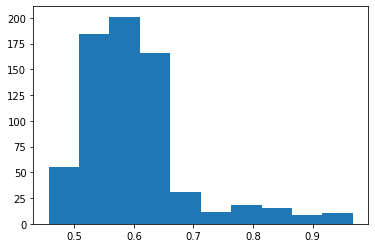

In [5]:
# print(data['human_expert_odom'][19][0:10])
# print('\n')
variances = []
for i in range(700):
    var_ = (np.asarray(data['future_joystick'][i][:150]).flatten()).var()
    variances.append(var_)
    # if var_ > 0.8:
    #     print(i)
    
# print(variances)
plt.hist(variances)
# new = np.asarray(flatten(data['human_expert_odom'][0][:50])).flatten()
# np.var(new)
# df = pd.DataFrame(new)
# df.head()

In [18]:
x = np.asarray(flatten(data['future_joystick'][2][:150])).flatten()
y = np.asarray(flatten(data['future_joystick'][3][:150])).flatten()
dist = ((x - y)**2).mean()
print(dist)

0.022679729775029436


In [41]:
# joystick_simularities = []
# masks = [1 for _ in range(len(data['future_joystick']))]
# count = 0
# for i, x in enumerate(data['future_joystick']):
#     x = np.asarray(flatten(x[:150])).flatten()
#     for j, y in enumerate(data['future_joystick'][i+1:]):
#         y = np.asarray(flatten(y[:150])).flatten()
#         dist = ((x - y)**2).mean()
#         if dist < 0.005:
#             masks[i] = 0
#             count+=1
#             break
#         # joystick_simularities.append(dist)
# print(count, len(data['future_joystick']))
# print(masks)
data = pickle.load(open(pickle_file_path[1].replace('_data.pkl', '_final.pkl'), 'rb'))
joystick_simularities = []
masks = [1 for _ in range(len(data['future_joystick']))]
count = 0
straight = np.asarray([1.6, 0, 0] * 150)
for i, x in enumerate(data['future_joystick']):
    x = np.asarray(flatten(x[:150])).flatten()
    dist = ((x - straight) ** 2).mean()
    joystick_simularities.append(dist)
    if dist < 0.005:
        masks[i] = 0
        count+=1
#     for j, y in enumerate(data['future_joystick'][i+1:]):
#         y = np.asarray(flatten(y[:150])).flatten()
#         dist = ((x - y)**2).mean()
#         if dist < 0.005:
#             masks[i] = 0
#             count+=1
#             break
#         # joystick_simularities.append(dist)
print(count, len(data['future_joystick']))
print(masks)



640 854
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

(array([580.,  90.,  28.,  15.,  27.,   5.,   7.,  17.,   4.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  ]),
 [<matplotlib.patches.Polygon at 0x7f0035d99f98>])

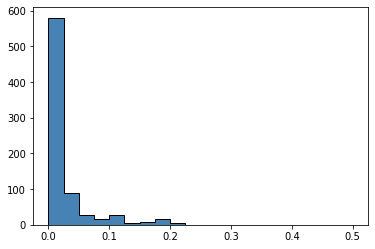

In [10]:
plt.hist(joystick_simularities, 20, range=(0, 0.5), histtype='stepfilled', color='steelblue', edgecolor='black')

In [5]:
x = 0
y = 0
for d in data['future_joystick']:
    x += 1
    if d[0][0] == 1.6 and d[0][1] == 0 and d[0][2] == 0:
        y += 1
print(x, y)

773 139


In [20]:
masks = [1 for _ in range(10)]
masks[5] = 0
masks[3] = 0
masks[7] = 0
idx = 7
idx = idx + masks[:idx].count(0)
idx

9

In [72]:
def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].reshape(n - 1, n + 1)[:, 1:].flatten()

x = np.array([[3,2,6,9],[1,7,8,11],[4,2,1,4]])
x = x - x.mean(axis=0)
print(x)
std_x = x.var(axis=0)
print(std_x)
cov_x = x.T @ x
cov_loss = (off_diagonal(cov_x)**2).sum() / 4
cov_loss
# x_new = off_diagonal(x)
# x_new
# x = np.expand_dims(np.asarray(data['future_joystick'][0][:2]).flatten(), axis=0)
# y = np.expand_dims(np.asarray(data['future_joystick'][100][:2]).flatten(), axis=0)
# x2 = np.expand_dims(np.asarray(data['future_joystick'][200][:2]).flatten(), axis=0)
# y2 = np.expand_dims(np.asarray(data['future_joystick'][300][:2]).flatten(), axis=0)
# x = np.append(x, x2, axis=0)
# y = np.append(y, y2, axis=0)
# cov_x = x.T @ x
# cov_y = y.T @ y
# print(cov_x.shape)
# cov_loss = off_diagonal(cov_x).pow_(2).sum().div(6)

# print(cov_loss)

[[ 0.33333333 -1.66666667  1.          1.        ]
 [-1.66666667  3.33333333  3.          3.        ]
 [ 1.33333333 -1.66666667 -4.         -4.        ]]
[1.55555556 5.55555556 8.66666667 8.66666667]


697.7222222222222

In [1]:
from social_nav_rep_learning import MyDataLoader

dl = MyDataLoader(data_path='./test/', batch_size=64, num_workers=32)

/home/fulinj/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/2 [00:00<?, ?it/s]

reading pickle file :  ./test/011-13-38_visualize_data.pkl
Pickle file exists. Loading from pickle file


 50%|█████     | 1/2 [00:01<00:01,  1.11s/it]

Delay frame is : 2
reading pickle file :  ./test/11-13-38_visualize_data.pkl
Pickle file exists. Loading from pickle file


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

Delay frame is : 2
Saving val and train dataset names in text files...
Dumped val and train dataset names in text files...
Loaded Datasets !!
Num training datapoints : 751
Num validation datapoints : 751


In [8]:
dl.training_dataset[750][1].shape

(300,)

In [5]:
import torch
from social_nav_rep_learning import PatchEmbedding

img = np.asarray([dl.validation_dataset[0][0],dl.validation_dataset[1][0]])
img = torch.from_numpy(img)
print(img.shape)

# v = SimpleViT(
#     image_size = 256,
#     patch_size = 32,
#     num_classes = 1000,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048
# )

preds = PatchEmbedding(240, 5, 16, 128)
print(preds.forward(img).shape)
# print(preds.forward(img))
print(img.shape)
img = img.unfold(2, 16, 16).unfold(3, 16, 16)
print(img.shape)
img = img.reshape(img.shape[0], img.shape[1], -1, 16, 16)
print(img.shape)
img = img.movedim(1, -1)
print(img.shape)
img = img.flatten(-3)
print(img.shape)

cls_token = nn.Parameter(torch.zeros((1, 1, 1280))).expand(2, -1, -1)
print(cls_token.shape)
x = torch.cat((cls_token, img), dim=1)
print(x.shape)
positional_embeddings = nn.Parameter(torch.zeros(1, 226, 1280))
print(positional_embeddings.shape)
x += positional_embeddings
print(x.shape)

torch.Size([2, 5, 240, 240])
torch.Size([2, 225, 128])
torch.Size([2, 5, 240, 240])
torch.Size([2, 5, 15, 15, 16, 16])
torch.Size([2, 5, 225, 16, 16])
torch.Size([2, 225, 16, 16, 5])
torch.Size([2, 225, 1280])
torch.Size([2, 1, 1280])
torch.Size([2, 226, 1280])
torch.Size([1, 226, 1280])
torch.Size([2, 226, 1280])


In [3]:
train_set = dl.train_dataloader()
train_iter = iter(train_set)
print(len(train_iter))
batch = next(train_iter)
print(batch[0].shape)
print(batch[1].shape)

11
torch.Size([64, 5, 401, 401])
torch.Size([64, 300])


In [14]:
masks = batch[4]
x = batch[1]
x = x[masks == 1]
print(x.shape)
print(masks)

torch.Size([48, 300])
tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])


In [21]:
masks = np.asarray([1 for _ in range(64)])
x = batch[1]
fixed_joy = batch[4]
for i, joy1 in enumerate(fixed_joy):
    for j, joy2 in enumerate(fixed_joy[i+1:]):
        dist = ((joy1 - joy2)**2).mean()
        if dist < 0.005:
            print(i,j+i+1)
            masks[i] = 0
            break
print(masks)
x = x[masks == 1]
print(x.shape)
repr_loss = ((x - 0.5 * x)**2).mean()
# repr_loss = (((((x - 0.5 * x)**2).T) * masks).T).mean()
repr_loss
# x[masks == 1].shape

1 13
2 39
5 14
6 7
7 26
8 9
9 10
10 14
13 16
14 17
15 24
16 18
17 19
18 20
19 27
20 21
24 27
26 28
27 33
28 35
29 47
32 33
33 36
34 47
35 37
36 38
37 47
38 45
45 49
46 49
47 48
48 60
49 50
51 53
53 57
[1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1]
torch.Size([29, 300])


tensor(3719.5782, dtype=torch.float64)

In [18]:
x = batch[1]
w = batch[3]
ms = (((x-0.5*x)**2).transpose(0,1) * w).transpose(0,1)
print(ms.shape)
repr_loss = (ms).mean()
print(repr_loss)

torch.Size([32, 300])
tensor(2298.6267, dtype=torch.float64)


In [24]:
def weighted_variance(x, weights):
    # x.shape should be (batch_size, d), weights.shape should be (batch_size, 1)
    ret = torch.clone(x)
    mean = x.mean(dim=0)
    v_1 = weights.sum()
    v_2 = weights.pow(2).sum()
    ret = (v_1 / (v_1 ** 2 - v_2)) * (((ret - mean).pow_(2).transpose(0,1) * weights).transpose(0,1)).sum(dim=0)
    return ret

x = batch[1]
x = x - x.mean(dim=0)
print(batch[3])
# std_x = torch.sqrt(weighted_variance(x, batch[3]) + 0.001)
std_x = torch.sqrt(x.var(dim=0) + 0.001)
print(std_x.shape)
std_loss = torch.mean(F.relu(1 - std_x)) / 2
print(std_loss)
# cov_x = x.T @ x / 3
# print(cov_x.shape)
# cov_loss = off_diagonal(cov_x).pow_(2).sum().div(128)
# print(cov_loss)

tensor([0.5958, 0.5820, 0.5061, 0.6029, 0.6717, 0.5350, 0.6442, 0.5827, 0.6029,
        0.4879, 0.6003, 0.5006, 0.6015, 0.6318, 0.5364, 0.7022, 0.5256, 0.5954,
        0.5229, 0.5826, 0.6235, 0.5278, 0.5189, 0.9530, 0.5056, 0.5967, 0.5371,
        0.5960, 0.5912, 0.5333, 0.5663, 0.5966, 0.6715, 0.4671, 0.4992, 0.6208,
        0.5846, 0.5954, 0.5988, 0.6015, 0.6336, 0.5527, 0.6138, 0.6590, 0.5138,
        0.5350, 0.5925, 0.5954, 0.5775, 0.5239, 0.5329, 0.6280, 0.5954, 0.5146,
        0.5089, 0.5674, 0.6947, 0.5018, 0.5566, 0.5425, 0.5880, 0.6541, 0.4746,
        0.5514, 0.5322, 0.5918, 0.8700, 0.5564, 0.5954, 0.5801, 0.5300, 0.6279,
        0.6462, 0.6333, 0.5386, 0.5352, 0.5751, 0.7345, 0.5910, 0.5935, 0.5230,
        0.6020, 0.5375, 0.5893, 0.6462, 0.5895, 0.6502, 0.6232, 0.5807, 0.6361,
        0.6755, 0.5955, 0.4780, 0.5438, 0.6147, 0.6025, 0.5366, 0.5252, 0.6404,
        0.7239, 0.5968, 0.6058, 0.6359, 0.6377, 0.5673, 0.6341, 0.5329, 0.5895,
        0.6925, 0.5228, 0.6626, 0.6293, 

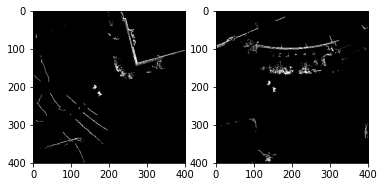

In [22]:
f, axes = plt.subplots(1,2) 
axes[0].imshow(batch[0][1][4].cpu().detach().numpy(), cmap=plt.cm.gray)
axes[1].imshow(batch[0][13][4].cpu().detach().numpy(), cmap=plt.cm.gray)

In [28]:
fixed_joy = batch[4]
joy1 = fixed_joy[1]
joy2 = fixed_joy[13]
dist = ((joy1 - joy2)**2).mean()
print("joystick space distance:", dist)

lid1 = batch[0][1]
lid2 = batch[0][13]
liddist = ((lid1 - lid2)**2).mean()
print("lidar scan space distance:", liddist)

joystick space distance: tensor(0.0020, dtype=torch.float64)
lidar scan space distance: tensor(0.0240)


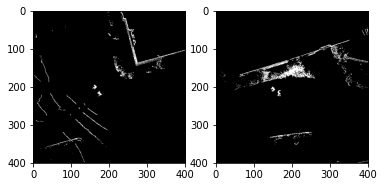

In [23]:
f, axes = plt.subplots(1,2) 
axes[0].imshow(batch[0][1][4].cpu().detach().numpy(), cmap=plt.cm.gray)
axes[1].imshow(batch[0][2][4].cpu().detach().numpy(), cmap=plt.cm.gray)

In [29]:
fixed_joy = batch[4]
joy1 = fixed_joy[1]
joy2 = fixed_joy[2]
dist = ((joy1 - joy2)**2).mean()
print("joystick space distance:", dist)

lid1 = batch[0][1]
lid2 = batch[0][2]
liddist = ((lid1 - lid2)**2).mean()
print("lidar scan space distance:", liddist)

joystick space distance: tensor(0.0435, dtype=torch.float64)
lidar scan space distance: tensor(0.0284)


tensor(19015.9996, dtype=torch.float64)

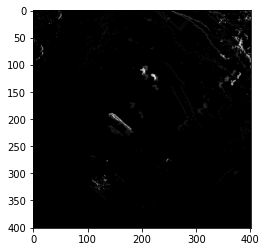

In [28]:
bev_lidar_image_initial = batch[0][2][0].cpu().detach().numpy()
for i in range(5):
    bev_lidar_image = batch[0][2][i].cpu().detach().numpy()
    bev_lidar_image_initial = cv2.addWeighted(bev_lidar_image_initial,1,bev_lidar_image,np.power(0.9,i*4),0)
plt.imshow(bev_lidar_image_initial, cmap=plt.cm.gray)
batch[1][2].var()

In [7]:
from social_nav_rep_learning import SNNetwork

encoder = SNNetwork(batch[1].shape[1], 240, 5, 16)
print(encoder.patch_embed(batch[0].float()).shape)
goal_embed = encoder.goal_embed(batch[2].float())
print(goal_embed.shape)
print(goal_embed.unsqueeze(1).shape)
img_batch = encoder.patch_embed(batch[0].float())
cls_token = encoder.cls_token.expand(batch[1].shape[0], -1, -1)
print(cls_token.shape)
img_batch = torch.cat((cls_token, img_batch), dim=1)
print(img_batch.shape)

preds = encoder(batch[0].float(), batch[1].float(), batch[2].float())

torch.Size([128, 225, 128])
torch.Size([128, 128])
torch.Size([128, 1, 128])
torch.Size([128, 1, 128])
torch.Size([128, 226, 128])


torch.Size([128, 8, 227, 227])
torch.Size([8, 225])
torch.Size([8, 15, 15])
(8, 240, 240)


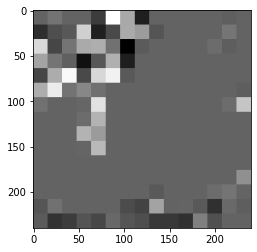

In [19]:
attentions = encoder.get_last_selfattention(batch[0].float(),batch[2].float())
print(attentions.shape)
nh = attentions.shape[1]
attentions = attentions[2, :, 0, 1:-1].reshape(nh, -1)
print(attentions.shape)
numfeat = batch[0].shape[-1] // 16
attentions = attentions.reshape(8, 240//16, 240//16)
print(attentions.shape)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().detach().numpy()
print(attentions.shape)
plt.imshow(attentions[0], cmap=plt.cm.gray)

In [9]:
from barlow_twins import off_diagonal
x = torch.rand(4,4)
print(x)
print(x.flatten()[:-1].view(3, 5))
print(off_diagonal(x))

tensor([[0.8006, 0.8211, 0.1849, 0.2454],
        [0.8230, 0.4263, 0.1540, 0.3580],
        [0.2750, 0.6491, 0.0663, 0.5137],
        [0.1071, 0.5331, 0.0574, 0.2680]])
tensor([[0.8006, 0.8211, 0.1849, 0.2454, 0.8230],
        [0.4263, 0.1540, 0.3580, 0.2750, 0.6491],
        [0.0663, 0.5137, 0.1071, 0.5331, 0.0574]])
tensor([0.8211, 0.1849, 0.2454, 0.8230, 0.1540, 0.3580, 0.2750, 0.6491, 0.5137,
        0.1071, 0.5331, 0.0574])


In [5]:
print(preds[0].shape==preds[1].shape)
# batch size
print(preds[0].shape[0])
print((preds[0].T @ preds[1]).shape)
for param_tensor in encoder.state_dict():
    print(param_tensor, "\t", encoder.state_dict()[param_tensor])
    break

True
2
torch.Size([128, 128])
cls_token 	 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [3]:
from skimage.measure import block_reduce
image = np.arange(5*401*401).reshape(5, 401, 401)
print(image.shape)
image = image[:, 80:320, 80:320]
# means = block_reduce(image, block_size=(1, 4, 4), func=np.mean)
# print(means.shape)
# vars = block_reduce(image, block_size=(1, 4, 4), func=np.var)
# image = np.concatenate((means, vars), axis=0)
print(image.shape)

(5, 401, 401)
(5, 240, 240)


/home/fulinj/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v not in values:


ValueError: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

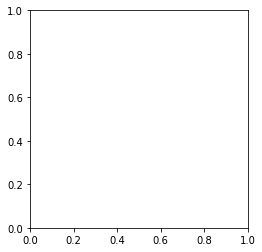

In [2]:
import os
import argparse
import glob
import numpy as np
import pickle
import cv2
from termcolor import cprint
from tqdm import tqdm
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

def get_affine_mat(x, y, theta):
    """
    Returns the affine transformation matrix for the given parameters.
    """
    theta = np.deg2rad(theta)
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta), np.cos(theta), y],
                     [0, 0, 1]])


def get_affine_matrix_quat(x, y, quaternion):
    theta = R.from_quat(quaternion).as_euler('XYZ')[2]
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta), np.cos(theta), y],
                     [0, 0, 1]])
data = pickle.load(open('./test/011-13-38_visualize_final.pkl', 'rb'))

bev_lidar_image = np.array(Image.open(os.path.join('./test/011-13-38_visualize_final/', f'{1}.png')))
# bev_lidar_image = cv2.cvtColor(bev_lidar_image, cv2.COLOR_GRAY2BGR)
# T_odom_robot = get_affine_matrix_quat(data['odom'][-1][0], data['odom'][-1][1], data['odom'][-1][2])
# for goal in data['human_expert_odom'][-1][:200]:
#     T_odom_goal = get_affine_matrix_quat(goal[0], goal[1], goal[2])
#     T_robot_goal = np.matmul(
#         np.linalg.pinv(T_odom_robot), T_odom_goal)
#     T_c_f = [T_robot_goal[0, 2], T_robot_goal[1, 2]]
#     t_f_pixels = [int(T_c_f[0] / 0.05) + 200,
#                 int(-T_c_f[1] / 0.05) + 200]
#     bev_lidar_image = cv2.circle(
#         bev_lidar_image, (t_f_pixels[0], t_f_pixels[1]), 1, (0, 0, 255), -1)
# cv2.imshow('bev_lidar', bev_lidar_image)